<a href="https://colab.research.google.com/github/msaad1311/Data-Imputation-using-DL/blob/master/Final_Code_Final_Take.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!python LIMELSTM.py

In [0]:
import pandas as pd
import numpy as np 
import random
import csv
import matplotlib.pyplot as plt
import xlwt 
import keras
import os
import tensorflow as tf
import reader
from keras import backend as K
from xlwt import Workbook
from keras import optimizers
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Bidirectional,Activation
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error

In [0]:
def data(dataframe,input_var,output_var):
  temp_input = dataframe[[input_var]]
  temp_output = dataframe[[output_var]]

  # temp_in_miss = misser(temp_input,percent)

  temp_in_miss = temp_input.copy(deep=True)

  temp_in_miss['Index_input']=np.arange(len(temp_in_miss))
  temp_output['Index_output']=np.arange(len(temp_output))

  temp_in_wna = temp_in_miss.dropna()
  temp_in_na = temp_in_miss[temp_in_miss[input_var].isnull()]

  output_train=temp_output[temp_output.index.isin(temp_in_wna['Index_input'])]
  output_pred= temp_output[temp_output.index.isin(temp_in_na['Index_input'])]

  return temp_in_wna,temp_in_na,output_train,output_pred

def misser (df,missing_percent = 0.5):
  for i in df.columns:
    for j, row_value in df[i].iteritems():
      if j==0:
        continue
      else:
        if random.random() <= missing_percent:
            df[i][j] = np.nan
  return df

def LR (input_wna,output_wna,input_na,output_na,input_var,output_var):
  reg = LinearRegression()
  reg.fit(
      (input_wna[input_var].to_numpy()).reshape(-1,1),
      output_wna[output_var].to_numpy()
      )
  ans=reg.predict(
      (input_na[input_var].to_numpy()).reshape(-1,1)
      )
  output_na[output_var]=ans.reshape(-1,1)

  return output_na

def SR (input_wna,output_wna,input_na,output_na,input_var,output_var):
  reg = SVR(C=1.0, epsilon=0.2)
  reg.fit(
      (input_wna[input_var].to_numpy()).reshape(-1,1),
      output_wna[output_var].to_numpy()
      )
  ans=reg.predict(
      (input_na[input_var].to_numpy()).reshape(-1,1)
      )
  output_na[output_var]=ans.reshape(-1,1)

  return output_na

def XGB (input_wna,output_wna,input_na,output_na,input_var,output_var):
  reg = ensemble.GradientBoostingRegressor(loss='huber')
  reg.fit(
      (input_wna[input_var].to_numpy()).reshape(-1,1),
      output_wna[output_var].to_numpy()
      )
  ans=reg.predict(
      (input_na[input_var].to_numpy()).reshape(-1,1)
      )
  output_na[output_var]=ans.reshape(-1,1)

  return output_na

def merger(input_wna,input_na):
  return (input_wna.append(input_na)).sort_values(by='Index_input')

def data_split(dataframe,percentage):
  training = dataframe[(dataframe.index>=np.percentile(dataframe.index, 0)) & (dataframe.index<=np.percentile(dataframe.index, percentage))]
  testing = dataframe[(dataframe.index>=np.percentile(dataframe.index, percentage)) & (dataframe.index<=np.percentile(dataframe.index, 100))]

  return training, testing

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)



# MACHINE LEARNING MODELS

In [0]:
df=pd.read_excel('Combined file_corn.xls')
df=df[['Area Planted', 'Area Harvested', 'Yield']]

df_missing = df[['Area Planted', 'Area Harvested']]

df_missing_file = misser(df_missing,0.50)

df_missing_file =pd.concat([df_missing_file,df["Yield"]],axis=1)

df_interpolated_LR,df_interpolated_SR,df_interpolated_XGB=df.copy(deep=True),df.copy(deep=True),df.copy(deep=True)

for i in df.columns:
  if i == "Yield":
    break
  else:
    # in_wna,in_na,out_wna,out_na= data(df_missing_file,i,'Yield')
    in_wna_LR,in_na_LR,out_wna_LR,out_na_LR=data(df_missing_file,i,'Yield')
    in_wna_SR,in_na_SR,out_wna_SR,out_na_SR=data(df_missing_file,i,'Yield')
    in_wna_XGB,in_na_XGB,out_wna_XGB,out_na_XGB=data(df_missing_file,i,'Yield')

    
    pred_output_LR = LR(out_wna_LR,in_wna_LR,out_na_LR,in_na_LR,'Yield',i)
    pred_output_SR = SR(out_wna_SR,in_wna_SR,out_na_SR,in_na_SR,'Yield',i)
    pred_output_XGB = XGB(out_wna_XGB,in_wna_XGB,out_na_XGB,in_na_XGB,'Yield',i)

    comp_input_LR=merger(pred_output_LR,in_wna_LR)
    comp_input_SR=merger(pred_output_SR,in_wna_SR)
    comp_input_XGB=merger(pred_output_XGB,in_wna_XGB)
    
    df_interpolated_LR[i]=comp_input_LR
    df_interpolated_SR[i]=comp_input_SR
    df_interpolated_XGB[i]=comp_input_XGB

# train_LR,test_LR = data_split(df_interpolated_LR,80)
# train_SR,test_SR = data_split(df_interpolated_SR,80)
# train_XGB,test_XGB = data_split(df_interpolated_XGB,80)

# RNN_run(train_LR,test_LR,500,50,"Linear Regression",lb=5,la=0,j=6)
# RNN_run(train_SR,test_SR,500,50,"SV Regression",lb=5,la=0,j=6)
# RNN_run(train_XGB,test_XGB,500,50,"XGBoost",lb=5,la=0,j=6)


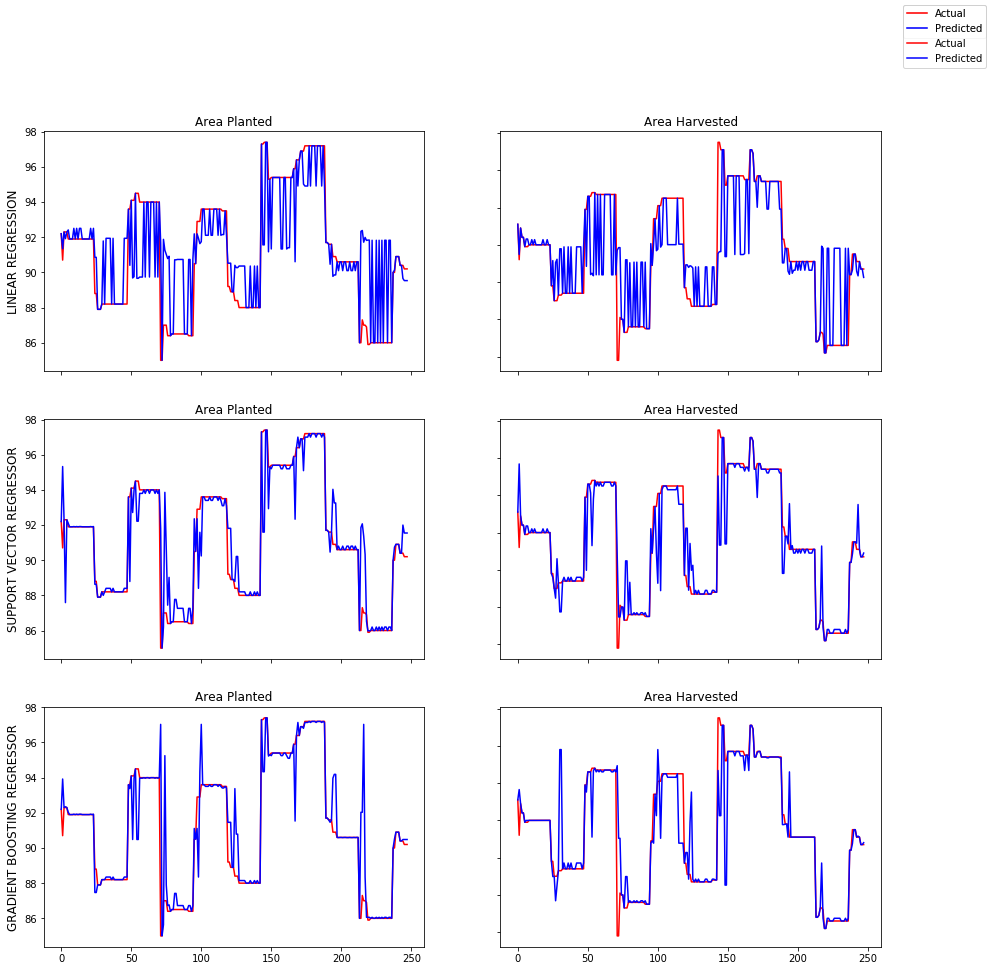

In [0]:
fig,axs = plt.subplots(3,2,figsize=(15,15))
ml_model = ['LINEAR REGRESSION','SUPPORT VECTOR REGRESSOR','GRADIENT BOOSTING REGRESSOR']

for i,j in zip(df.columns,range(0,len(df.columns))):
    if i=='Yield':
        break
    axs[0,j].plot(df[i],color='r',label="Actual")
    axs[0,j].plot(df_interpolated_LR[i],color='b',label='Predicted')
    axs[0,j].set_title("{}".format(i))
    fig.legend()

for k,l in zip(df.columns,range(0,len(df.columns))):
    if k=='Yield':
        break
    axs[1,l].plot(df[k],color='r',label="Actual")
    axs[1,l].plot(df_interpolated_SR[k],color='b',label='Predicted')
    axs[1,l].set_title("{}".format(k))

for p,q in zip(df.columns,range(0,len(df.columns))):
    if p=='Yield':
        break
    axs[2,q].plot(df[p],color='r',label="Actual")
    axs[2,q].plot(df_interpolated_XGB[p],color='b',label='Predicted')
    axs[2,q].set_title("{}".format(p))


for ax, row in zip(axs[:,0], ml_model):
  ax.set_ylabel(row,size='large')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()




fig.savefig("Machine Learning Models.png")



In [0]:
print("Mean Square Error for Linear Regression Interpolation is:",mse(df,df_interpolated_LR))
print("Mean Square Error for Support Vector Regressor Interpolation is:",mse(df,df_interpolated_SR))
print("Mean Square Error for Gradient Boosting Regressor Interpolation is:",mse(df,df_interpolated_XGB))

Mean Square Error for Linear Regression Interpolation is: 3.5620411991705185
Mean Square Error for Support Vector Regressor Interpolation is: 1.1138624848593985
Mean Square Error for Gradient Boosting Regressor Interpolation is: 1.4951628705047149


# LIME Section

In [0]:
df_lime= df.copy(deep=True)
df_lime=df_lime.drop(columns=['Yield'])
df_lime.head()

In [0]:
df_lime.to_csv('raw.txt', header=None, index=None, sep='\t', mode='a')
df_missing.fillna(-1.0).to_csv('miss_data.txt', header=None, index=None, sep=' ', mode='a')

In [0]:
!python LIMELSTM.py



W1220 20:36:54.542163 139695825942400 module_wrapper.py:139] From LIMELSTM.py:113: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


W1220 20:36:54.542421 139695825942400 module_wrapper.py:139] From LIMELSTM.py:116: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2019-12-20 20:36:54.547100: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-20 20:36:54.547276: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f9abc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-20 20:36:54.547306: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-20 20:36:54.548993: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-20 20:36:54.649263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successf

In [0]:
df_lstm = pd.read_excel('imputed_data_epochfor.xlsx')
df_lstm.columns=['Area Planted','Area Harvested']
df_lstm=pd.concat([df_lstm,df['Yield']],axis=1)
df_lstm.head()

In [0]:
mse(df,df_lstm)

In [0]:
!python LIMEGRU.py



W1220 20:47:09.371179 140328108390272 module_wrapper.py:139] From LIMEGRU.py:113: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


W1220 20:47:09.371444 140328108390272 module_wrapper.py:139] From LIMEGRU.py:116: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2019-12-20 20:47:09.376151: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-20 20:47:09.376329: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1784bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-20 20:47:09.376357: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-20 20:47:09.378006: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-20 20:47:09.474691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful

In [0]:
df_gru = pd.read_excel('imputed_data_ for LIME GRU.xlsx')
df_gru.columns=['Area Planted','Area Harvested']
df_gru=pd.concat([df_gru,df['Yield']],axis=1)
df_gru.head()

In [0]:
mse(df,df_gru)

0.6417933047715056

In [0]:
!python LIMERNN.py



W1220 20:49:24.345675 140621428930432 module_wrapper.py:139] From LIMERNN.py:113: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


W1220 20:49:24.345976 140621428930432 module_wrapper.py:139] From LIMERNN.py:116: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2019-12-20 20:49:24.352468: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-20 20:49:24.352650: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x16ecbc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-20 20:49:24.352679: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-20 20:49:24.354352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-20 20:49:24.451774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful

In [0]:
df_rnn = pd.read_excel('imputed_data_ for LIME RNN.xlsx')
df_rnn.columns=['Area Planted','Area Harvested']
df_rnn=pd.concat([df_rnn,df['Yield']],axis=1)
df_rnn.head()

,Area Planted,Area Harvested,Yield
0,92.1875,85.1250,158.7
1,92.6875,85.0625,158.7
2,92.3125,84.8750,158.7
3,92.1875,84.3750,153.0
4,92.3125,84.3750,148.1


In [0]:
mse(df,df_rnn)

3.5026425991263452

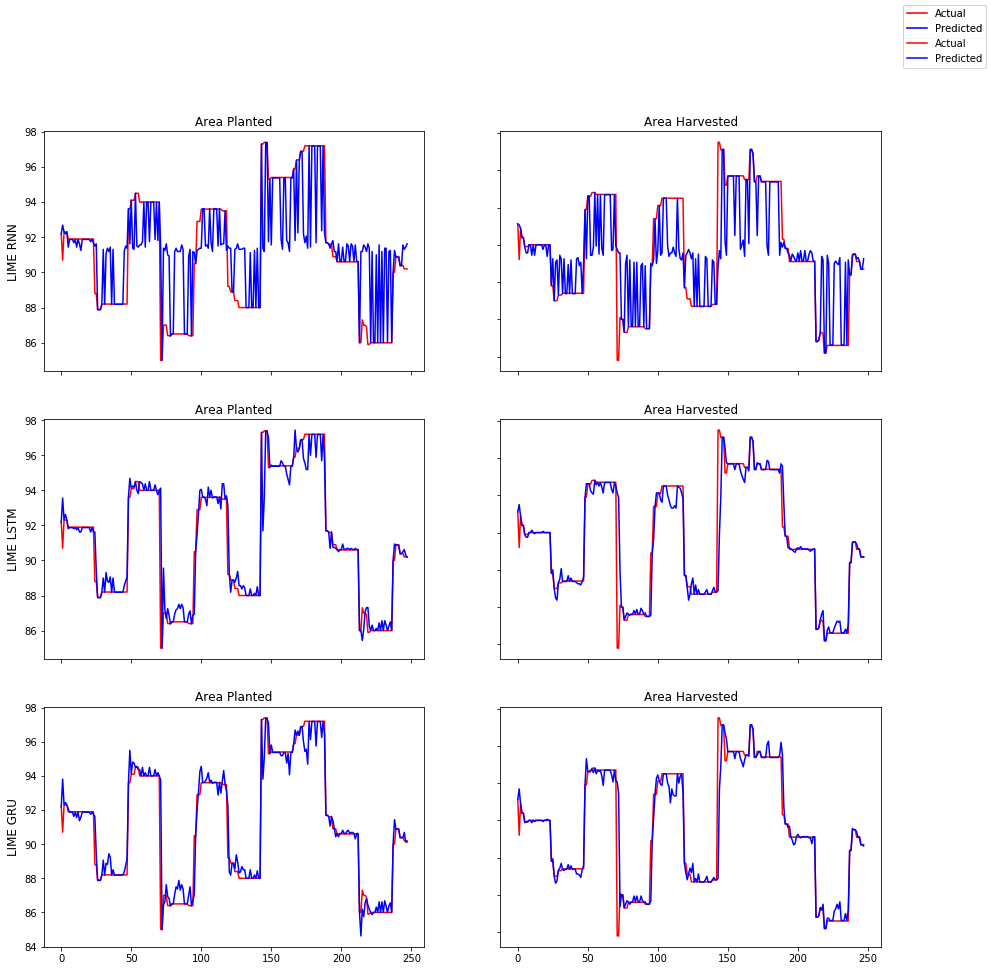

In [0]:
fig,axs = plt.subplots(3,2,figsize=(15,15))
dl_model = ['LIME RNN','LIME LSTM','LIME GRU']

for i,j in zip(df.columns,range(0,len(df.columns))):
    if i=='Yield':
        break
    axs[0,j].plot(df[i],color='r',label="Actual")
    axs[0,j].plot(df_rnn[i],color='b',label='Predicted')
    axs[0,j].set_title("{}".format(i))
    fig.legend()

for k,l in zip(df.columns,range(0,len(df.columns))):
    if k=='Yield':
        break
    axs[1,l].plot(df[k],color='r',label="Actual")
    axs[1,l].plot(df_lstm[k],color='b',label='Predicted')
    axs[1,l].set_title("{}".format(k))

for p,q in zip(df.columns,range(0,len(df.columns))):
    if p=='Yield':
        break
    axs[2,q].plot(df[p],color='r',label="Actual")
    axs[2,q].plot(df_gru[p],color='b',label='Predicted')
    axs[2,q].set_title("{}".format(p))


for ax, row in zip(axs[:,0], dl_model):
  ax.set_ylabel(row,size='large')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()




fig.savefig("Deep Learning Models.png")



# STATISTICAL METHODS

In [0]:
# Plugging in the average
df_avg = df_missing_file.copy(deep=True)
df_med =df_missing_file.copy(deep=True)
df_forward = df_missing_file.copy(deep=True)
df_mode = df_missing_file.copy(deep=True)

df_avg=df_avg.fillna(df.mean())
df_med =df_med.fillna(df.median())
df_forward=df_forward.fillna(method='ffill')

for i in df.columns:
    df_mode=df_mode.fillna(df[i].mode()[0])


In [0]:
print(mse(df,df_avg))
print(mse(df,df_med))
print(mse(df,df_forward))
print(mse(df,df_mode))

3.7621398606035172
3.7548252688172057
0.9586424731182803
8.368373655913985


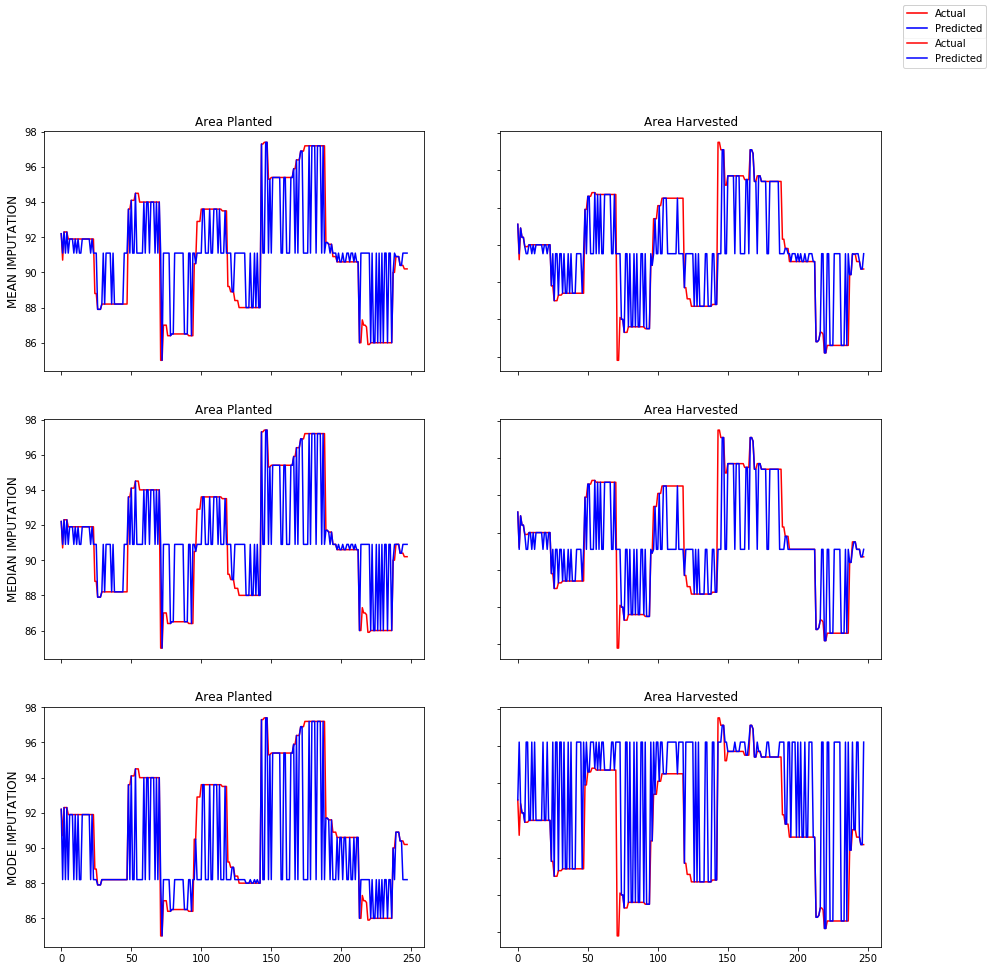

In [0]:
fig,axs = plt.subplots(3,2,figsize=(15,15))
stats_model = ['MEAN IMPUTATION','MEDIAN IMPUTATION','MODE IMPUTATION']

for i,j in zip(df.columns,range(0,len(df.columns))):
    if i=='Yield':
        break
    axs[0,j].plot(df[i],color='r',label="Actual")
    axs[0,j].plot(df_avg[i],color='b',label='Predicted')
    axs[0,j].set_title("{}".format(i))
    fig.legend()

for k,l in zip(df.columns,range(0,len(df.columns))):
    if k=='Yield':
        break
    axs[1,l].plot(df[k],color='r',label="Actual")
    axs[1,l].plot(df_med[k],color='b',label='Predicted')
    axs[1,l].set_title("{}".format(k))

for p,q in zip(df.columns,range(0,len(df.columns))):
    if p=='Yield':
        break
    axs[2,q].plot(df[p],color='r',label="Actual")
    axs[2,q].plot(df_mode[p],color='b',label='Predicted')
    axs[2,q].set_title("{}".format(p))


for ax, row in zip(axs[:,0], stats_model):
  ax.set_ylabel(row,size='large')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()




fig.savefig("Statistical Models.png")



# Experimentation

In [0]:
f=open('raw.txt','r')
content =f.read()

df = pd.DataFrame([x.split('\t') for x in content.split('\n')])

In [0]:
df.drop(df.tail(1).index,inplace=True)

In [0]:
df1 = pd.read_excel('imputed_data_epochfor.xlsx')

In [0]:
from math import sqrt
sqrt(mse(df,df1))

0.5175097612051773

In [0]:
f=open('miss_data.txt','r')
content =f.read()

df1 = pd.DataFrame([x.split(' ') for x in content.split('\n')])

In [0]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.43799,0.49805,3.625,3.6445,5.0,2.918,5.0,2.3516,2.332,2.6426,1.6982,1.6865,1.6982,1.7168,1.7441,0.59277,0.50195,0.49292,0.50391,0.44507,0.43091,0.44409,0.43994,0.42896,
1,0.43799,-1.0,-1.0,3.6484,-1.0,2.918,-1.0,-1.0,-1.0,2.6484,1.6953,1.6865,-1.0,-1.0,-1.0,0.5918,0.50195,0.49292,-1.0,0.44897,0.43091,-1.0,0.44312,-1.0,
2,0.43799,-1.0,3.625,3.6289,5.0,-1.0,-1.0,-1.0,2.334,-1.0,1.6963,1.6865,-1.0,-1.0,-1.0,-1.0,0.50195,-1.0,-1.0,0.44897,0.43091,0.44409,-1.0,0.42896,
3,0.43701,0.50098,3.625,-1.0,-1.0,-1.0,-1.0,-1.0,2.334,2.6426,-1.0,-1.0,1.6953,-1.0,-1.0,0.59277,0.50195,0.49292,0.50391,0.44897,0.43091,-1.0,-1.0,0.42896,
4,0.43799,0.49805,-1.0,-1.0,-1.0,2.918,-1.0,2.6406,2.334,-1.0,1.6963,1.6865,-1.0,-1.0,-1.0,-1.0,0.50195,0.49292,0.50391,-1.0,-1.0,-1.0,-1.0,0.42896,


In [0]:
df1.replace('-1.0',np.nan,inplace=True)

In [0]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.43799,0.49805,3.625,3.6445,5.0,2.918,5.0,2.3516,2.332,2.6426,1.6982,1.6865,1.6982,1.7168,1.7441,0.59277,0.50195,0.49292,0.50391,0.44507,0.43091,0.44409,0.43994,0.42896,
1,0.43799,NaN,NaN,3.6484,NaN,2.918,NaN,NaN,NaN,2.6484,1.6953,1.6865,NaN,NaN,NaN,0.5918,0.50195,0.49292,NaN,0.44897,0.43091,NaN,0.44312,NaN,
2,0.43799,NaN,3.625,3.6289,5.0,NaN,NaN,NaN,2.334,NaN,1.6963,1.6865,NaN,NaN,NaN,NaN,0.50195,NaN,NaN,0.44897,0.43091,0.44409,NaN,0.42896,
3,0.43701,0.50098,3.625,NaN,NaN,NaN,NaN,NaN,2.334,2.6426,NaN,NaN,1.6953,NaN,NaN,0.59277,0.50195,0.49292,0.50391,0.44897,0.43091,NaN,NaN,0.42896,
4,0.43799,0.49805,NaN,NaN,NaN,2.918,NaN,2.6406,2.334,NaN,1.6963,1.6865,NaN,NaN,NaN,NaN,0.50195,0.49292,0.50391,NaN,NaN,NaN,NaN,0.42896,


In [0]:
df2=df1.astype(float).interpolate()

In [0]:
raw_data,columns,normalizer = reader.read_raw_data('raw.txt')

In [0]:
miss_data = reader.read_missing_data("miss_data.txt", normalizer, 24)

In [0]:
miss_data=pd.DataFrame(miss_data)

In [0]:
miss_data.replace(-1.0,np.nan,inplace=True)

In [0]:
miss_data=miss_data.interpolate()

In [0]:
sqrt(mse(raw_data,miss_data))

0.10799172115091277